# Import Necessary Libraries

In [1]:
from PIL import Image
import torch
from datasets import load_dataset
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import BertTokenizer
import torch.nn as nn
import torchvision.models as models
from transformers import BertModel


# Check for GPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#output the name of cuda device
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 3060 Laptop GPU


# Loading Dataset

In [3]:
base_path = 'pvqa/'

pvqa_dic_path = base_path + 'pvqa_dictionary.pkl'
test_img_id2idx_path = base_path + 'test_img_id2idx.pkl'
train_img_id2idx_path = base_path + 'train_img_id2idx.pkl'
val_img_id2idx_path = base_path + 'val_img_id2idx.pkl'

pvqa_dic_pkl = pd.read_pickle(pvqa_dic_path)
test_img_id2idx_pkl = pd.read_pickle(test_img_id2idx_path)
train_img_id2idx_pkl = pd.read_pickle(train_img_id2idx_path)
val_img_id2idx_pkl = pd.read_pickle(val_img_id2idx_path)

In [4]:
qas_base_path = base_path + 'qas/'

q2a_path = qas_base_path + 'q2a.pkl'
ans2lbl_path = qas_base_path + 'ans2label.pkl'
qid2a_path = qas_base_path + 'qid2a.pkl'
qid2q_path = qas_base_path + 'qid2q.pkl'
test_vqa_path = qas_base_path + 'test_vqa.pkl'
train_vqa_path = qas_base_path + 'train_vqa.pkl'
val_vqa_path = qas_base_path + 'val_vqa.pkl'
train_qa_path = qas_base_path + 'train/train_qa.pkl'
trainval_ans2lbl_path = qas_base_path + 'trainval_ans2label.pkl'
trainval_lbl2ans_path = qas_base_path + 'trainval_label2ans.pkl'

q2a_pairs = pd.read_pickle(q2a_path)
ans2lbl_pairs = pd.read_pickle(ans2lbl_path)
qid2a_pairs = pd.read_pickle(qid2a_path)
qid2q_pairs = pd.read_pickle(qid2q_path)
test_vqa_pairs = pd.read_pickle(test_vqa_path)
train_vqa_pairs = pd.read_pickle(train_vqa_path)
train_qa_pairs = pd.read_pickle(train_qa_path)
val_vqa_pairs = pd.read_pickle(val_vqa_path)
trainval_lbl2ans_pairs = pd.read_pickle(trainval_lbl2ans_path)
trainval_ans2lbl_pairs = pd.read_pickle(trainval_ans2lbl_path)

In [5]:
train_vqa_df = pd.DataFrame(train_vqa_pairs)
val_vqa_df = pd.DataFrame(val_vqa_pairs)
test_vqa_df = pd.DataFrame(test_vqa_pairs)

In [6]:
test_vqa_df

,answer_type,img_id,label,question_id,question_type,sent
0,other,test_0167,{'the histone subunits': 1},300167000,what,"What are positively charged, thus allowing th..."
1,other,test_0167,{'positively charged': 1},300167001,how,How are the histone subunits charged?
2,yes/no,test_0167,{'yes': 1},300167002,are,"Are the histone subunits positively charged, ..."
3,other,test_0099,{'the principal cellular alterations that char...,300099000,what,What are illustrated?
4,yes/no,test_0099,{'yes': 1},300099001,are,Are the principal cellular alterations that ch...
...,...,...,...,...,...,...
6756,other,test_0648,{'kidney': 1},300648002,what,What is present?
6757,yes/no,test_0648,{'yes': 1},300648003,is,Is kidney present?
6758,other,test_0648,{'sarcoidosis': 1},300648004,what,What is present?
6759,yes/no,test_0648,{'yes': 1},300648005,is,Is sarcoidosis present?


In [7]:
train_vqa_df

,answer_type,img_id,label,question_id,question_type,sent
0,other,train_0422,{'in the canals of hering': 1},100422000,where,Where are liver stem cells (oval cells) located?
1,other,train_0422,{'bile duct cells and canals of hering': 1},100422001,what,What are stained here with an immunohistochemi...
2,other,train_0422,{'an immunohistochemical stain': 1},100422002,what,What are bile duct cells and canals of Hering ...
3,yes/no,train_0422,{'yes': 1},100422003,are,Are bile duct cells and canals of Hering stain...
4,other,train_0986,{'an infarct in the brain': 1},100986000,what,What shows dissolution of the tissue?
...,...,...,...,...,...,...
19750,other,train_2794,{'urinary': 1},102794003,where,Where is this?
19751,other,train_2584,{'polyarteritis nodosa': 1},102584000,what,What does this image show?
19752,yes/no,train_2584,{'yes': 1},102584001,does,"Does this image show polyarteritis nodosa, kid..."
19753,yes/no,train_2584,{'no': 1},102584002,does,"Does cytomegaly show polyarteritis nodosa, kid..."


In [8]:
val_vqa_df

,answer_type,img_id,label,question_id,question_type,sent
0,other,val_0261,{'neutrophils': 1},200261000,what,What have lost their nuclei?
1,other,val_0261,{'neutrophils': 1},200261001,whose,Whose nuclei have been lost?
2,other,val_0261,{'their': 1},200261002,two,Two have lost whose nuclei ?
3,other,val_0178,{'the embolus': 1},200178000,what,What is composed of hematopoietic marrow and m...
4,other,val_0178,{'hematopoietic marrow and marrow fat cells': 1},200178001,what,What is the embolus composed of?
...,...,...,...,...,...,...
6274,other,val_0919,{'urinary': 1},200919005,where,Where is this?
6275,other,val_0849,{'polyarteritis nodosa': 1},200849000,what,What does this image show?
6276,yes/no,val_0849,{'yes': 1},200849001,does,"Does this image show polyarteritis nodosa, kid..."
6277,yes/no,val_0849,{'no': 1},200849002,does,Does metastatic carcinoma lung show polyarteri...


In [9]:
tr_q = list(train_vqa_df['sent'])
val_q = list(val_vqa_df['sent'])
ts_q = list(test_vqa_df['sent'])

tr_a = [q2a_pairs[each] for each in tr_q]
val_a = [q2a_pairs[each] for each in val_q]
ts_a = [q2a_pairs[each] for each in ts_q]

qs = [tr_q, val_q, ts_q]
ans = [tr_a, val_a, ts_a]

del tr_q, tr_a, ts_q, ts_a, val_q, val_a

In [10]:
val_lens = [len(each) for each in qs[1]]
tr_lens = [len(each) for each in qs[0]]
ts_lens = [len(each) for each in qs[2]]

print('Question with maximum length in validation set:', max(val_lens))
print('Question with minimum length in validation set:', min(val_lens))
print('Question with maximum length in training set:', max(tr_lens))
print('Question with minimum length in training set:', min(tr_lens))
print('Question with maximum length in test set:', max(ts_lens))
print('Question with minimum length in test set:', min(ts_lens))

del tr_lens, val_lens, ts_lens

Question with maximum length in validation set: 252
Question with minimum length in validation set: 8
Question with maximum length in training set: 255
Question with minimum length in training set: 9
Question with maximum length in test set: 264
Question with minimum length in test set: 8


In [11]:
idx = 0
ans2lbl_len = 4092
ans2lbl_keys = list(ans2lbl_pairs.keys())

for each in ans:
	for i in range(len(each)):
		if each[i] not in ans2lbl_keys:
			ans2lbl_pairs[each[i]] = ans2lbl_len + idx
			idx += 1

del ans2lbl_keys

In [12]:
num_classes = len(list(ans2lbl_pairs.keys()))
print(num_classes)
anss = list(ans2lbl_pairs.keys())
lbls = list(range(0, len(anss)))
ans2lbl_pairs = dict(zip(anss, lbls))

del anss, lbls

4645


In [13]:
dfs = [train_vqa_df, val_vqa_df, test_vqa_df]

del train_vqa_df, val_vqa_df, test_vqa_df

for i in range(len(dfs)):
    dfs[i]['question'] = dfs[i]['sent']
    dfs[i]['answer'] = pd.Series(ans[i])
    dfs[i]['label'] = pd.Series([ans2lbl_pairs[each] for each in ans[i]])

    if i == 0:
        dfs[i]['img_id'] = base_path + 'images/train/' + dfs[i]['img_id']
    elif i == 1:
        dfs[i]['img_id'] = base_path + 'images/val/' + dfs[i]['img_id']
    else:
        dfs[i]['img_id'] = base_path + 'images/test/' + dfs[i]['img_id']

    dfs[i].drop(['sent', 'answer_type', 'question_id', 'question_type'], axis=1, inplace=True)

In [14]:
dfs[0]

,img_id,label,question,answer
0,pvqa/images/train/train_0422,0,Where are liver stem cells (oval cells) located?,in the canals of hering
1,pvqa/images/train/train_0422,1,What are stained here with an immunohistochemi...,bile duct cells and canals of hering
2,pvqa/images/train/train_0422,2,What are bile duct cells and canals of Hering ...,an immunohistochemical stain
3,pvqa/images/train/train_0422,3,Are bile duct cells and canals of Hering stain...,yes
4,pvqa/images/train/train_0986,4,What shows dissolution of the tissue?,an infarct in the brain
...,...,...,...,...
19750,pvqa/images/train/train_2794,3203,Where is this?,urinary
19751,pvqa/images/train/train_2584,4115,What does this image show?,giant cells and fibrosis
19752,pvqa/images/train/train_2584,3,"Does this image show polyarteritis nodosa, kid...",yes
19753,pvqa/images/train/train_2584,6,"Does cytomegaly show polyarteritis nodosa, kid...",no


# Spilitting Dataset Into Free Form Questions

In [15]:
def extract_free_form(df):
    # Filter out the rows where answer is not yes, not no, and not a number
    return df[(df['answer'] != 'yes') & (df['answer'] != 'no')]


In [16]:
train_free_form = extract_free_form(dfs[0])
val_free_form = extract_free_form(dfs[1])
test_free_form = extract_free_form(dfs[2])

In [17]:
train_free_form

,img_id,label,question,answer
0,pvqa/images/train/train_0422,0,Where are liver stem cells (oval cells) located?,in the canals of hering
1,pvqa/images/train/train_0422,1,What are stained here with an immunohistochemi...,bile duct cells and canals of hering
2,pvqa/images/train/train_0422,2,What are bile duct cells and canals of Hering ...,an immunohistochemical stain
4,pvqa/images/train/train_0986,4,What shows dissolution of the tissue?,an infarct in the brain
5,pvqa/images/train/train_0986,5,What does an infarct in the brain show of the ...,dissolution of the tissue
...,...,...,...,...
19746,pvqa/images/train/train_2792,3203,Where is this?,urinary
19747,pvqa/images/train/train_2794,2513,What is present?,sarcoidosis
19750,pvqa/images/train/train_2794,3203,Where is this?,urinary
19751,pvqa/images/train/train_2584,4115,What does this image show?,giant cells and fibrosis


In [18]:
val_free_form

,img_id,label,question,answer
0,pvqa/images/val/val_0261,1282,What have lost their nuclei?,neutrophils
1,pvqa/images/val/val_0261,1282,Whose nuclei have been lost?,neutrophils
2,pvqa/images/val/val_0261,36,Two have lost whose nuclei ?,their
3,pvqa/images/val/val_0178,3273,What is composed of hematopoietic marrow and m...,the embolus
4,pvqa/images/val/val_0178,3274,What is the embolus composed of?,hematopoietic marrow and marrow fat cells
...,...,...,...,...
6268,pvqa/images/val/val_0921,3203,Where is this?,urinary
6271,pvqa/images/val/val_0919,2513,What is present?,sarcoidosis
6274,pvqa/images/val/val_0919,3203,Where is this?,urinary
6275,pvqa/images/val/val_0849,4115,What does this image show?,giant cells and fibrosis


# Using BERT to Process Textual Part of VQA

In [19]:
text_processor = BertTokenizer.from_pretrained('bert-base-uncased')
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomAffine(0, shear=10, scale=(0.9,1.1)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'other':
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

# Data Loader

In [20]:
class VQADataset(torch.utils.data.Dataset):
    def __init__(self,
                df,
                text_processor,
                img_transform,
                shuffle_data=True):

        self.df = df
        self.text_processor = text_processor
        self.max_len = 32

        if shuffle_data:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

        self.img_transform = img_transform

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx) -> tuple:
        image = Image.open(self.df.iloc[idx, 0] + '.jpg').convert("RGB")
        question = self.df.iloc[idx, 2]
        label = self.df.iloc[idx, 1]

        if self.img_transform:
            image = self.img_transform(image)
        encoding = self.text_processor(
                                  question,
                                  padding="max_length",
                                  truncation=True,
                                  max_length = self.max_len,
                                  return_tensors="pt"
                                  )
        # Remove batch dimension
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)

        return image, input_ids, attention_mask, label

# Model Architecture

In [21]:
import torch
import torch.nn as nn
import torchvision.models as models
from transformers import BertModel

class Attention(nn.Module):
    def __init__(self, image_dim, question_dim, hidden_dim):
        super(Attention, self).__init__()
        self.image_fc = nn.Linear(image_dim, hidden_dim)
        self.question_fc = nn.Linear(question_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, image_features, question_features):
        # Linear transformations
        image_proj = self.image_fc(image_features)
        question_proj = self.question_fc(question_features).unsqueeze(1)
        
        # Combine projections
        combined_proj = torch.tanh(image_proj + question_proj)
        attention_weights = torch.softmax(self.fc(combined_proj), dim=1)
        
        # Weighted sum of image features
        attended_image_features = (attention_weights * image_features).sum(dim=1)
        
        return attended_image_features, attention_weights

class VQAModel(nn.Module):
    def __init__(self, num_answers):
        super(VQAModel, self).__init__()
        # Image feature extractor using VGG-19
        vgg = models.vgg19(pretrained=True)
        self.vgg_features = vgg.features
        self.vgg_classifier = nn.Sequential(*list(vgg.classifier.children())[:-1])
        self.vgg_fc = nn.Linear(4096, 512)

        # Question feature extractor using BERT
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.bert_fc = nn.Linear(768, 512)

        # Attention layers
        self.attention1 = Attention(512, 512, 512)
        self.attention2 = Attention(512, 512, 512)

        # Combined classifier
        self.fc1 = nn.Linear(512 + 512, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_answers)

        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, images, input_ids, attention_mask):
        # Image features
        with torch.no_grad():
            img_features = self.vgg_features(images)
        img_features = img_features.view(img_features.size(0), -1)
        img_features = self.vgg_classifier(img_features)
        img_features = self.vgg_fc(img_features)
        
        # Question features
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        ques_features = self.bert_fc(bert_output.pooler_output)

        # Attention layers
        attended_img_features1, _ = self.attention1(img_features, ques_features)
        attended_img_features2, _ = self.attention2(attended_img_features1, ques_features)

        # Concatenate features
        combined_features = torch.cat((attended_img_features2, ques_features), dim=1)

        # Classification
        x = self.fc1(combined_features)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        output = self.fc3(x)

        return output

# Setting-Up The Model For Training

In [22]:
from sklearn.metrics import accuracy_score

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0

        # Training
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}-Training', leave=False)
        for images, input_ids, attention_mask, labels in progress_bar:
            images, input_ids, attention_mask, labels = images.to(device), input_ids.to(device), attention_mask.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            train_acc += accuracy_score(labels.cpu(), preds.cpu())
        
        # Validation
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            progress_bar = tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs}-Validation', leave=False)
            for images, input_ids, attention_mask, labels in progress_bar:
                images, input_ids, attention_mask, labels = images.to(device), input_ids.to(device), attention_mask.to(device), labels.to(device)
                outputs = model(images, input_ids, attention_mask)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_acc += accuracy_score(labels.cpu(), preds.cpu())

        # Calculate average losses and accuracies
        train_loss = train_loss / len(train_loader)
        train_acc = train_acc / len(train_loader)
        val_loss = val_loss / len(val_loader)
        val_acc = val_acc / len(val_loader)

        print(f'Epoch: {epoch+1}/{num_epochs}.. Training Loss: {train_loss}.. Training Accuracy: {train_acc}.. Validation Loss: {val_loss}.. Validation Accuracy: {val_acc}')
    scheduler.step()

## Loading the Dataset

In [23]:
batch_size = 64

train_dataset = VQADataset(df=train_free_form, text_processor=text_processor,img_transform=data_transforms['train'])
val_dataset = VQADataset(df=val_free_form, text_processor=text_processor, img_transform=data_transforms['other'])
test_dataset = VQADataset(df=test_free_form, text_processor=text_processor, img_transform=data_transforms['other'])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Training the Model for Free Form Questions

In [24]:
# Hyperparameters
num_epochs = 10
learning_rate = 5e-5

# Model, criterion, optimizer   
model = VQAModel(num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# Training
train_model(model, train_loader,val_loader, criterion, optimizer, num_epochs, scheduler)

# Save the trained model
torch.save(model.state_dict(), 'vqa_model_free_form.pth')
print("Model saved successfully.")

c:\ProgramData\anaconda3\envs\pt\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\envs\pt\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10-Training:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 1/10-Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1/10.. Training Loss: 260.1127975094013.. Training Accuracy: 0.33560363247863245.. Validation Loss: 173.3047382259369.. Validation Accuracy: 0.5210267857142857


Epoch 2/10-Training:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 2/10-Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 2/10.. Training Loss: 179.13971833540842.. Training Accuracy: 0.48424145299145305.. Validation Loss: 160.699655148983.. Validation Accuracy: 0.5594642857142857


Epoch 3/10-Training:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 3/10-Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 3/10.. Training Loss: 164.67015832662582.. Training Accuracy: 0.5228031517094017.. Validation Loss: 158.21579923152925.. Validation Accuracy: 0.5594642857142857


Epoch 4/10-Training:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 4/10-Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 4/10.. Training Loss: 159.13155414202274.. Training Accuracy: 0.536091079059829.. Validation Loss: 173.10433636665346.. Validation Accuracy: 0.5541517857142857


Epoch 5/10-Training:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 5/10-Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 5/10.. Training Loss: 158.04566952509757.. Training Accuracy: 0.5296474358974359.. Validation Loss: 164.94746630430222.. Validation Accuracy: 0.5638392857142857


Epoch 6/10-Training:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 6/10-Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 6/10.. Training Loss: 152.906099823805.. Training Accuracy: 0.5386284722222222.. Validation Loss: 163.05399853944778.. Validation Accuracy: 0.5641517857142857


Epoch 7/10-Training:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 7/10-Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 7/10.. Training Loss: 151.15975277851788.. Training Accuracy: 0.54296875.. Validation Loss: 174.62226150274276.. Validation Accuracy: 0.5650892857142857


Epoch 8/10-Training:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 8/10-Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 8/10.. Training Loss: 149.8242320433641.. Training Accuracy: 0.5486444978632479.. Validation Loss: 164.3163992714882.. Validation Accuracy: 0.5663392857142857


Epoch 9/10-Training:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 9/10-Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 9/10.. Training Loss: 147.25591574571072.. Training Accuracy: 0.550247061965812.. Validation Loss: 169.71574850320815.. Validation Accuracy: 0.5638392857142857


Epoch 10/10-Training:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 10/10-Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 10/10.. Training Loss: 146.52899415982074.. Training Accuracy: 0.5530849358974359.. Validation Loss: 167.90557054042816.. Validation Accuracy: 0.5782142857142857
Model saved successfully.


# Calculating Test Accuracy of Free Form Model

In [24]:
# Load the trained model
model = VQAModel(num_classes)
model.load_state_dict(torch.load('vqa_model_free_form.pth'))
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Test the trained model on test_free_form
model.eval()
test_acc = 0.0
test_loss = 0.0
with torch.no_grad():
    for images, input_ids, attention_mask, labels in test_loader:
        images, input_ids, attention_mask, labels = images.to(device), input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(images, input_ids, attention_mask)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        test_acc += accuracy_score(labels.cpu(), preds.cpu())

test_loss = test_loss / len(test_loader)
test_acc = test_acc / len(test_loader)
print(f'Test Loss: {test_loss}.. Test Accuracy: {test_acc}')

c:\ProgramData\anaconda3\envs\pt\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\envs\pt\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Loss: 177.33988521683892.. Test Accuracy: 0.5562247304582211


# Graphs

In [25]:
def plot_graphs(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss of Yes/No Model')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy of Yes/No Model')
    plt.legend()

    plt.show()

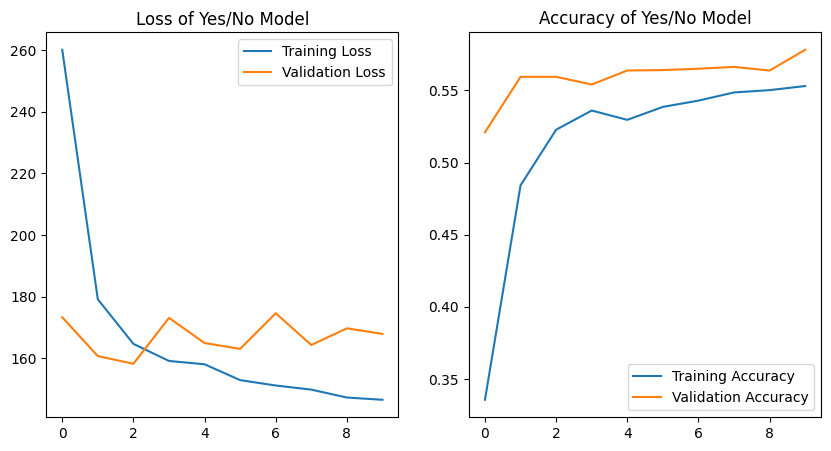

In [26]:
train_acc = [0.33560363247863245, 0.48424145299145305, 0.5228031517094017, 0.536091079059829, 0.5296474358974359, 0.5386284722222222, 0.54296875, 0.5486444978632479, 0.550247061965812, 0.5530849358974359]
val_acc = [0.5210267857142857, 0.5594642857142857, 0.5594642857142857, 0.5541517857142857, 0.5638392857142857, 0.5641517857142857, 0.5650892857142857, 0.5663392857142857, 0.5638392857142857, 0.5782142857142857]
train_loss = [260.1127975094013, 179.13971833540842, 164.67015832662582, 159.13155414202274, 158.04566952509757, 152.906099823805, 151.15975277851788, 149.8242320433641, 147.25591574571072, 146.52899415982074]
val_loss = [173.3047382259369, 160.699655148983, 158.21579923152925, 173.10433636665346, 164.94746630430222, 163.05399853944778, 174.62226150274276, 164.3163992714882, 169.71574850320815, 167.90557054042816]


plot_graphs(train_loss, val_loss, train_acc, val_acc)